## Applying AI to Image Reconstruction task: LLMs focused !

**Module:** Deep Neural Networks and Learning Systems

**Supervised By:** Jimenez Rodriguez Alejandro

**Developer's Information:** Sheema Firdous

Submitted as a part of module assessment at Schoole of Business an dComputing, Sheffield Hallam University - United Kingdom

## Importing Libraries

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F


In [ ]:
from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
root_dir = '/content/drive/MyDrive/SHU/Neural Networks and Learning Systems'

algonauts_dir = 'algonauts_2023_tutorial_data' # Path to the shortcut in your drive
reduced_images_dir = 'reduced_images_algonauts' # Path to the shortcut in your drive

# Loading reduced images
reduced_images = np.load( os.path.join(root_dir, reduced_images_dir, 'subj01', 'images.npy') )

Setting up the dataset

The dataset is located in a different drive (public). Therefore, we need to add a shortcut to the data directory in our own drive.

**Original dataset**

Open the dataset external drive: [https://drive.google.com/drive/folders/1DUf3nGNNFk6YjRjQtZPfAY5N105GoGJb](https://drive.google.com/drive/folders/1DUf3nGNNFk6YjRjQtZPfAY5N105GoGJb) and click in add shortcut.

**Reduced images**

I have also created a separate folder with reduced size images to accelerate model training. *You also need a shortcut to this folder in your own drive*:

https://drive.google.com/drive/folders/18niX9leMkIxIhD1st-f6yR0s1HWTGBkV?usp=drive_link

## Building a dataset.

First we create a dataset that represents ALL the brain activity. If you want to use a particular region you need to modify this class

## Utility functions

The following functions can be used to load the FMRI data from a given subject, load activity from a given region of interest or loading the corresponding image.

In [ ]:
# @title Helper functions
# Loads all the fmri data associated to a given subject
def load_fmri_of_subject( subj, hemisphere, directory = root_dir ):
  subj = subj # Subject
  hemisphere = hemisphere # Which side of the brain
  # Listing directory
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))
  return brain_activity

# Loads the data associated to a specific part of the brain (Some will be empty, it varies by subject)
def load_fmri_region_of_interest( subj, roi, hemisphere, directory = root_dir):
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
    # Define the ROI class based on the selected ROI
  if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
      roi_class = 'prf-visualrois'
  elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
      roi_class = 'floc-bodies'
  elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
      roi_class = 'floc-faces'
  elif roi in ["OPA", "PPA", "RSC"]:
      roi_class = 'floc-places'
  elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
      roi_class = 'floc-words'
  elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
      roi_class = 'streams'

  # Loading the roi masks (To locate the activations of a given region)
  roi_class_dir = os.path.join(data_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
  roi_map_dir = os.path.join(data_dir, 'roi_masks',
      'mapping_'+roi_class+'.npy')
  roi_class_idx = np.load(roi_class_dir)
  roi_map = np.load(roi_map_dir, allow_pickle=True).item()
  roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
  challenge_roi = np.asarray(roi_class_idx == roi_mapping, dtype=int)

  # Selection the appropriate data
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

  fmri_roi_data = brain_activity[:,np.where(challenge_roi)[0]]

  return fmri_roi_data

# Load a particular image from a subject
def load_image_subject( subj, img, directory = root_dir):
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
  train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
  test_img_dir  = os.path.join(data_dir, 'test_split', 'test_images')
  train_img_list = os.listdir(train_img_dir)
  train_img_list.sort()
  test_img_list = os.listdir(test_img_dir)
  test_img_list.sort()

  img_dir = os.path.join(train_img_dir, train_img_list[img])
  train_img = Image.open(img_dir).convert('RGB') # Image library (PIL)
  return train_img

def load_reduced_image_subject( subj, img, directory = root_dir ):
  image = reduced_images[img]

  return Image.fromarray(image)

def showImage( ax, image, title = '' ):
  ''' This is a helper function that allows you to show the results of your training '''
  image = (image - torch.min(image))/(torch.max(image)-torch.min(image)) # image 0...1
  ax.imshow(image.permute(1,2,0)) # You need reorganize the dimension (3, H,  W) -> (H, W, 3)
  ax.set_title(title)


In [ ]:
# This dataset provides batches of image, brain activity, pairs
class BrainDataSet(Dataset):
  def __init__( self, subject, hemisphere, transform = None ):
    self.subject = subject # We need to select a particular object
    self.hemisphere = hemisphere
    self.fmri_data = load_fmri_of_subject( subject, hemisphere ) # Load all the data from the subjects
    self.data_len, self.num_samples = self.fmri_data.shape # Get the shape MxN
    self.transform = transform

  def __len__(self):
    return self.data_len # len is the total number of images

  def __getitem__( self, idx ):
    # Get FMRI data
    x = self.fmri_data[idx, :]
    # Obtain images
    img = load_reduced_image_subject( subj = self.subject, img = idx ) # This is slow. If you can you should preload all images
    return self.transform(img) if self.transform else img, torch.from_numpy(x),


subject = 1 # change this to change the subject
hemisphere = 1 # change this to change the hemisphere (1 left, 2 right)
# You define to define a transform:
# 1. Convert the images to Tensors
# 2. Resize (32, 32)
# 3. Normalize
resize_normalize = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.Resize((32,32)), # We downsample the images a lot. Bigger images take more time to train
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

# Create the dataset
myDataset = BrainDataSet( subject, hemisphere, resize_normalize)

Creating our train loader

In [ ]:
# Creating a data loader
# Shuffles
# Organizes in batches
train_loader = DataLoader( dataset = myDataset,
                          #  num_workers = 2, # Parallel to make it faster
                          #  prefetch_factor=16, # This is used to preload some of the data
                           batch_size = 32,
                           shuffle = True )

torch.Size([32, 3, 32, 32])


Text(0.5, 1.0, 'Brain activity')

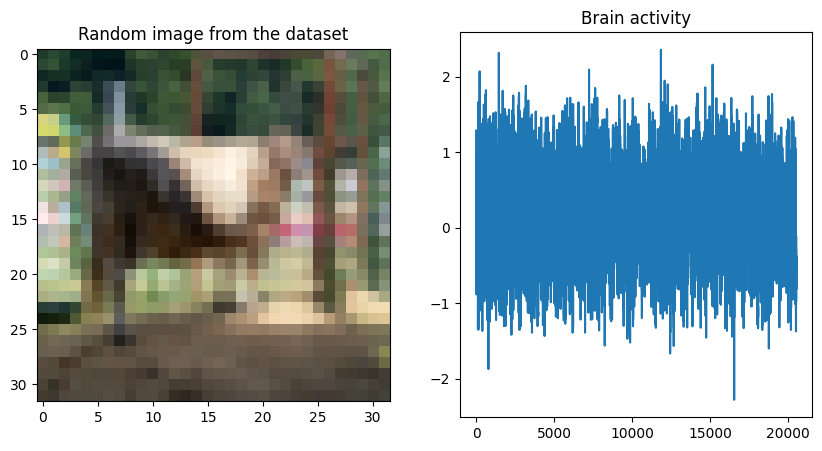

In [ ]:
img, fmri = next(iter(train_loader))

print(img.shape)
fig, ax = plt.subplots(1,2, figsize = (10, 5))

showImage( ax[0], img[0], 'Random image from the dataset')
ax[1].plot(fmri[0])
ax[1].set_title('Brain activity')

## Experiments: Autoencoder + CNN

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        super().__init__()
        c_hid = base_channel_size  # 32
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 4 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Conv2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1, stride=2),  # 4x4 => 2x2
            act_fn(),
            nn.Flatten(),  # Flatten the feature map
            nn.Linear(4 * c_hid * 2 * 2, latent_dim),  # Fully connected layer to latent space
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        super().__init__()
        self.c_hid = base_channel_size  # Store as an instance variable
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * self.c_hid * 2 * 2),  # Match the flattened size of the 2x2 feature map
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                4 * self.c_hid, 4 * self.c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 2x2 => 4x4
            act_fn(),
            nn.Conv2d(4 * self.c_hid, 4 * self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                4 * self.c_hid, 2 * self.c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * self.c_hid, 2 * self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                2 * self.c_hid, self.c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(self.c_hid, self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                self.c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 16x16 => 32x32
        )

    def forward(self, x):
        x = self.linear(x)  # Map latent space to 4 * c_hid * 2 * 2
        x = x.reshape(x.shape[0], 4 * self.c_hid, 2, 2)  # Reshape to [batch_size, 4 * c_hid, 2, 2]
        x = self.net(x)  # Decode to reconstruct the image
        return x


### Training an Autoencoder First....

In [ ]:
class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 3,
        width: int = 32,
        height: int = 32,
    ):
        super().__init__()
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

    def forward(self, x):
        z = self.encoder(x) # Latent code
        x_hat = self.decoder(z) # Reconstruction
        return x_hat



In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Toggle training mode
Train_mode = True
# Region of interest and model file naming
region_of_interest = "V1d_left_512dim"
model_filename = f'autoencoder_{region_of_interest}.pt'
latent_dimension = 512  # Dimensionality of latent space

def autoencoder_train(latent_dim, loss_fn=nn.MSELoss()):
    """
    Trains an autoencoder model on the specified data using MSE loss.

    Parameters:
    - latent_dim (int): Dimensionality of the latent space.
    - loss_fn (torch.nn.modules.loss._Loss): Loss function to use (default: MSE).

    Returns:
    - model (nn.Module): Trained autoencoder.
    - epoch_avg_losses (np.ndarray): Mean loss per epoch.
    - epoch_std_losses (np.ndarray): Std deviation of loss per epoch.
    """
    print("[INFO] Starting training of autoencoder...")

    checkpoint_path = 'autoencoder_checkpoint.pt'
    learning_rate = 1e-3
    total_epochs = 50

    # Initialize the model
    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss_fn

    # Containers to store loss metrics
    epoch_avg_losses = np.zeros(total_epochs)
    epoch_std_losses = np.zeros(total_epochs)

    for epoch in range(total_epochs):
        batch_losses = []

        print(f"[INFO] Epoch {epoch+1}/{total_epochs}...")
        for batch_idx, (inputs, _) in enumerate(train_loader):
            inputs = inputs.to(device)

            # Forward pass
            reconstructed = model(inputs)

            # Loss computation
            loss = criterion(inputs, reconstructed)
            batch_losses.append(loss.item())

            # Display periodic training updates
            if batch_idx % 100 == 0:
                print(f"  -> Batch {batch_idx}, Loss: {loss.item():.6f}")

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute epoch statistics
        epoch_avg = np.mean(batch_losses)
        epoch_std = np.std(batch_losses)
        epoch_avg_losses[epoch] = epoch_avg
        epoch_std_losses[epoch] = epoch_std

        print(f"[INFO] Epoch {epoch+1} complete. Mean Loss: {epoch_avg:.6f}, Std: {epoch_std:.6f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_avg
        }, checkpoint_path)
        print("[CHECKPOINT] Saved model checkpoint.")

    # Save final trained model to Google Drive
    final_model_path = f"/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models/{model_filename}"
    torch.save(model.state_dict(), final_model_path)
    print(f"[SUCCESS] Final model saved to {final_model_path}")

    return model, epoch_avg_losses, epoch_std_losses

[MODE] Training mode activated.
[INFO] Starting training of autoencoder...
[INFO] Epoch 1/50...
  -> Batch 0, Loss: 1.135278
  -> Batch 100, Loss: 0.697106
  -> Batch 200, Loss: 0.522998
  -> Batch 300, Loss: 0.396944
[INFO] Epoch 1 complete. Mean Loss: 0.662743, Std: 0.228529
[CHECKPOINT] Saved model checkpoint.
[INFO] Epoch 2/50...
  -> Batch 0, Loss: 0.452051
  -> Batch 100, Loss: 0.400532
  -> Batch 200, Loss: 0.380291
  -> Batch 300, Loss: 0.448041
[INFO] Epoch 2 complete. Mean Loss: 0.446389, Std: 0.040993
[CHECKPOINT] Saved model checkpoint.
[INFO] Epoch 3/50...
  -> Batch 0, Loss: 0.464200
  -> Batch 100, Loss: 0.351743
  -> Batch 200, Loss: 0.352905
  -> Batch 300, Loss: 0.375691
[INFO] Epoch 3 complete. Mean Loss: 0.400417, Std: 0.037910
[CHECKPOINT] Saved model checkpoint.
[INFO] Epoch 4/50...
  -> Batch 0, Loss: 0.358155
  -> Batch 100, Loss: 0.426179
  -> Batch 200, Loss: 0.360504
  -> Batch 300, Loss: 0.317940
[INFO] Epoch 4 complete. Mean Loss: 0.366585, Std: 0.033715
[C

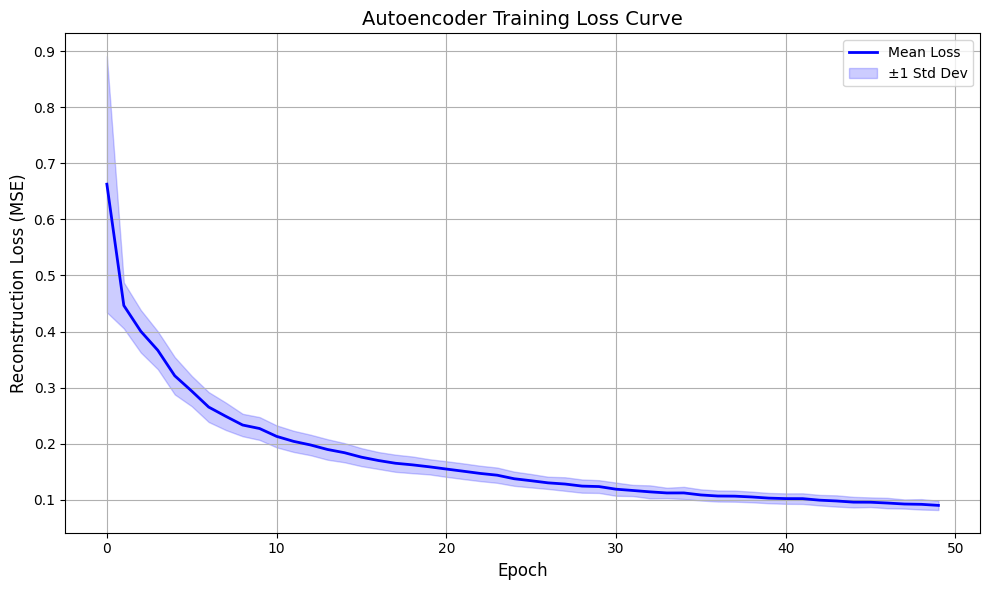

[STATUS] Autoencoder ready for inference.


In [ ]:
# Define loss function
reconstruction_loss = nn.MSELoss()

# Toggle between training and evaluation
if Train_mode:
    print("[MODE] Training mode activated.")
    autoencoder_model, avg_loss_per_epoch, std_loss_per_epoch = autoencoder_train(latent_dimension, reconstruction_loss)

    # Plotting the training loss with shaded std deviation
    epochs_range = np.arange(len(avg_loss_per_epoch))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, avg_loss_per_epoch, label='Mean Loss', color='blue', linewidth=2)
    plt.fill_between(epochs_range,
                     avg_loss_per_epoch - std_loss_per_epoch,
                     avg_loss_per_epoch + std_loss_per_epoch,
                     color='blue', alpha=0.2, label='±1 Std Dev')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Reconstruction Loss (MSE)', fontsize=12)
    plt.title('Autoencoder Training Loss Curve', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("[MODE] Evaluation mode. Loading pretrained model...")
    autoencoder_model = Autoencoder(base_channel_size=32, latent_dim=latent_dimension)

    pretrained_model_path = f'/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models/{model_filename}'
    autoencoder_model.load_state_dict(torch.load(pretrained_model_path))
    print(f"[LOADED] Pretrained weights loaded from {pretrained_model_path}")

# Send model to device and set to eval mode
autoencoder_model.to(device)
autoencoder_model.eval()
print("[STATUS] Autoencoder ready for inference.")


In [ ]:
class CosineLossOnly(nn.Module):
    """
    Computes a cosine similarity-based loss where higher similarity yields lower loss.
    """

    def __init__(self):
        super(CosineLossOnly, self).__init__()

    def forward(self, prediction_vec, target_vec):
        """
        Args:
            prediction_vec: Predicted vectors [batch_size, latent_dim]
            target_vec: Ground truth vectors [batch_size, latent_dim]

        Returns:
            Mean cosine dissimilarity loss (1 - cosine similarity)
        """
        # Flatten if needed (e.g., for image feature maps)
        pred_flat = prediction_vec.view(prediction_vec.size(0), -1)
        target_flat = target_vec.view(target_vec.size(0), -1)

        # Cosine similarity per sample
        cosine_sim = F.cosine_similarity(pred_flat, target_flat, dim=1)

        # Convert similarity into loss
        return 1.0 - cosine_sim.mean()

class LinearCompressor(nn.Module):
    """
    Reduces the dimensionality of input vectors using fully connected layers.
    """

    def __init__(self, original_dim, target_dim):
        super(LinearCompressor, self).__init__()

        self.compress_net = nn.Sequential(
            nn.Linear(original_dim, original_dim // 2),  # Intermediate shrink
            nn.ReLU(),
            nn.Linear(original_dim // 2, target_dim),    # Final dimensionality
            nn.ReLU()
        )

    def forward(self, input_tensor):
        """
        Args:
            input_tensor: [batch_size, original_dim]

        Returns:
            Compressed output: [batch_size, target_dim]
        """
        return self.compress_net(input_tensor)


In [ ]:
class CNN_decoder(nn.Module):
    """
    A 1D CNN decoder that maps brain signal vectors to latent image embeddings.
    """

    def __init__(self, brain_input_size, latent_vector_size, base_filters=64):
        super(CNN_decoder, self).__init__()  # ✅ Correct class name here

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, base_filters, kernel_size=7, stride=2, padding=3),  # [B, 1, 828] -> [B, 64, 414]
            nn.ReLU(),

            nn.Conv1d(base_filters, base_filters * 2, kernel_size=5, stride=2, padding=2),  # -> [B, 128, 207]
            nn.ReLU(),

            nn.Conv1d(base_filters * 2, base_filters * 4, kernel_size=3, stride=2, padding=1),  # -> [B, 256, 104]
            nn.ReLU(),

            nn.Conv1d(base_filters * 4, base_filters * 8, kernel_size=3, stride=2, padding=1),  # -> [B, 512, 52]
            nn.ReLU()
        )

        self.temporal_pooling = nn.AdaptiveAvgPool1d(output_size=16)  # -> [B, 512, 16]

        self.dense_layers = nn.Sequential(
            nn.Linear(base_filters * 8 * 16, base_filters * 4),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(base_filters * 4, latent_vector_size)
        )

    def forward(self, brain_input):
        """
        Args:
            brain_input: Tensor of shape [batch_size, brain_input_size]
        Returns:
            Latent representation: [batch_size, latent_vector_size]
        """
        x = brain_input.unsqueeze(1)       # [B, 1, input_dim]
        x = self.feature_extractor(x)      # Convolutions
        x = self.temporal_pooling(x)       # Downsample time dimension
        x = x.view(x.size(0), -1)          # Flatten
        latent_code = self.dense_layers(x) # Fully connected layers
        return latent_code


[INFO] Starting CNN Decoder training...
  [Batch 0] Loss: 0.997895
  [Batch 50] Loss: 0.989357
  [Batch 100] Loss: 0.961064
  [Batch 150] Loss: 0.969401
  [Batch 200] Loss: 0.958424
  [Batch 250] Loss: 0.945147
  [Batch 300] Loss: 0.917452
[Epoch 1/50] Avg Loss: 0.954206
  [Batch 0] Loss: 0.946314
  [Batch 50] Loss: 0.923786
  [Batch 100] Loss: 0.917328
  [Batch 150] Loss: 0.907007
  [Batch 200] Loss: 0.925411
  [Batch 250] Loss: 0.938639
  [Batch 300] Loss: 0.898234
[Epoch 2/50] Avg Loss: 0.926594
  [Batch 0] Loss: 0.958085
  [Batch 50] Loss: 0.936451
  [Batch 100] Loss: 0.919401
  [Batch 150] Loss: 0.884608
  [Batch 200] Loss: 0.881425
  [Batch 250] Loss: 0.897434
  [Batch 300] Loss: 0.933650
[Epoch 3/50] Avg Loss: 0.914555
  [Batch 0] Loss: 0.922514
  [Batch 50] Loss: 0.881137
  [Batch 100] Loss: 0.929949
  [Batch 150] Loss: 0.846174
  [Batch 200] Loss: 0.872819
  [Batch 250] Loss: 0.898826
  [Batch 300] Loss: 0.847066
[Epoch 4/50] Avg Loss: 0.903763
  [Batch 0] Loss: 0.912295
  [Ba

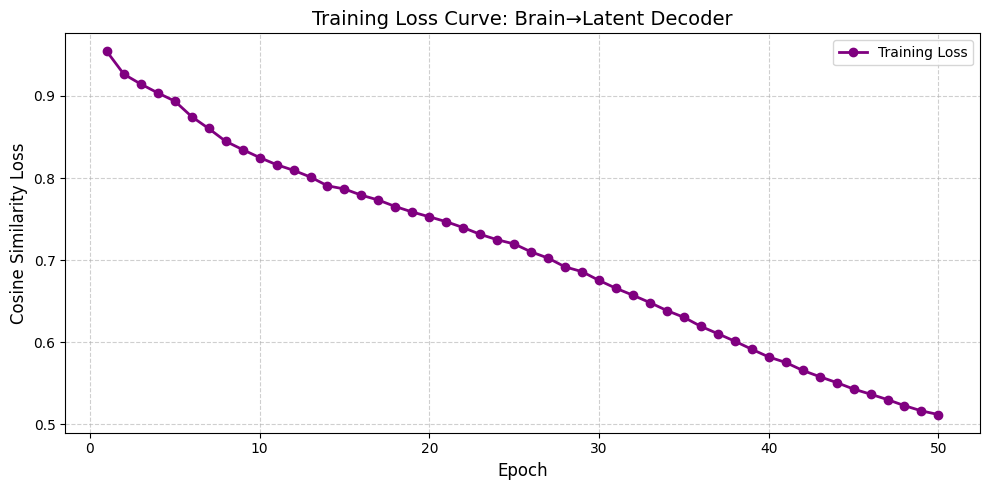

[DONE] Decoder training complete.


In [ ]:
# Model configuration
brain_input_dim = 828        # Dimensionality of brain signal input
latent_space_dim = 512       # Dimensionality of image encoder output (latent vector)

# Initialize the brain-to-latent decoder
brain_to_latent_model = CNN_decoder(brain_input_dim, latent_space_dim).to(device)

# Set up optimizer and loss function
decoder_optimizer = torch.optim.Adam(brain_to_latent_model.parameters(), lr=1e-4)
cosine_loss_fn = CosineLossOnly()  # similarity function call

# Training settings
total_epochs = 100
epoch_losses = []

print("[INFO] Starting CNN Decoder training...")

for epoch_idx in range(total_epochs):
    epoch_running_loss = 0.0

    for batch_idx, (img_batch, brain_signal_batch) in enumerate(train_loader):
        # Move batches to device
        img_batch = img_batch.to(device)
        brain_signal_batch = brain_signal_batch.to(device)

        # Generate target latent code using pre-trained autoencoder
        with torch.no_grad():  # not to update autoencoder weights....
            target_latent = autoencoder_model.encoder(img_batch)

        # Predict latent code from brain signals
        predicted_latent =  brain_to_latent_model(brain_signal_batch)

        # Calculating cosine similarity loss
        loss = cosine_loss_fn(predicted_latent, target_latent)
        epoch_running_loss += loss.item()

        # Backpropagation.......
        decoder_optimizer.zero_grad()
        loss.backward()
        decoder_optimizer.step()

        # Displaying intermediate batch info
        if batch_idx % 50 == 0:
            print(f"  [Batch {batch_idx}] Loss: {loss.item():.6f}")

    # Computing and storing epoch average loss
    average_epoch_loss = epoch_running_loss / len(train_loader)
    epoch_losses.append(average_epoch_loss)
    print(f"[Epoch {epoch_idx + 1}/{total_epochs}] Avg Loss: {average_epoch_loss:.6f}")

# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, total_epochs + 1), epoch_losses, color='purple', marker='o', linewidth=2, label='Training Loss')
plt.title("Training Loss Curve: Brain→Latent Decoder", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cosine Similarity Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

print("[DONE] Decoder training complete.")


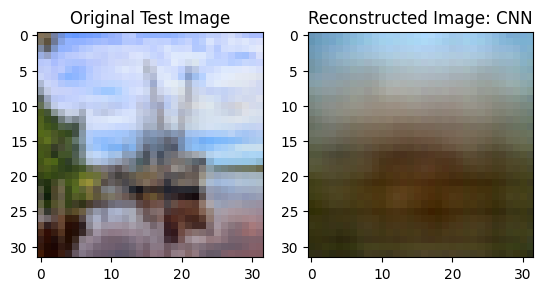

In [ ]:
# First you get the brain activity from train loader
image, brain_activity = next(iter(train_loader))

# Second you pass it through your BrainDecoder model
z_brain = brain_to_latent_model(brain_activity.to(device))

# Third you pass z_brain (latent code) through the decoder of the autoencoder
reconstructed_image = autoencoder_model.decoder(z_brain)

# Move output to CPU for visualization
reconstructed_image = reconstructed_image.detach().to('cpu')

# Plot original and reconstructed images
fig, ax = plt.subplots(1, 2)
showImage(ax[0], image[0, :, :, :], title='Original Test Image')
showImage(ax[1], reconstructed_image[0, :, :, :], title='Reconstructed Image: CNN')


## Experiments: Transformers

In [ ]:
import torch
import torch.nn as nn
import math

class TransformerBrainDecoder(nn.Module):
    def __init__(
        self,
        input_dim,             # Dimensionality of brain signal input
        d_model=512,           # Transformer embedding dimension
        nhead=4,
        num_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        latent_dim=512         # Output latent vector size
    ):
        super().__init__()

        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Output projection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, latent_dim)
        )

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.input_projection(x)
        x = x.unsqueeze(1)  # Add sequence dimension: (batch_size, 1, d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)  # Remove sequence dimension
        latent = self.output_projection(x)
        return latent


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.transpose(0, 1)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


[DEVICE] Using device: cuda
[INFO] Brain activity input dimension: 20544
[INFO] Latent space dimension expected: 512
[CHECKPOINT] Loaded model from epoch 100
[LOG] Cosine similarity values saved to /content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models/transformer_cosine_similarity.pt


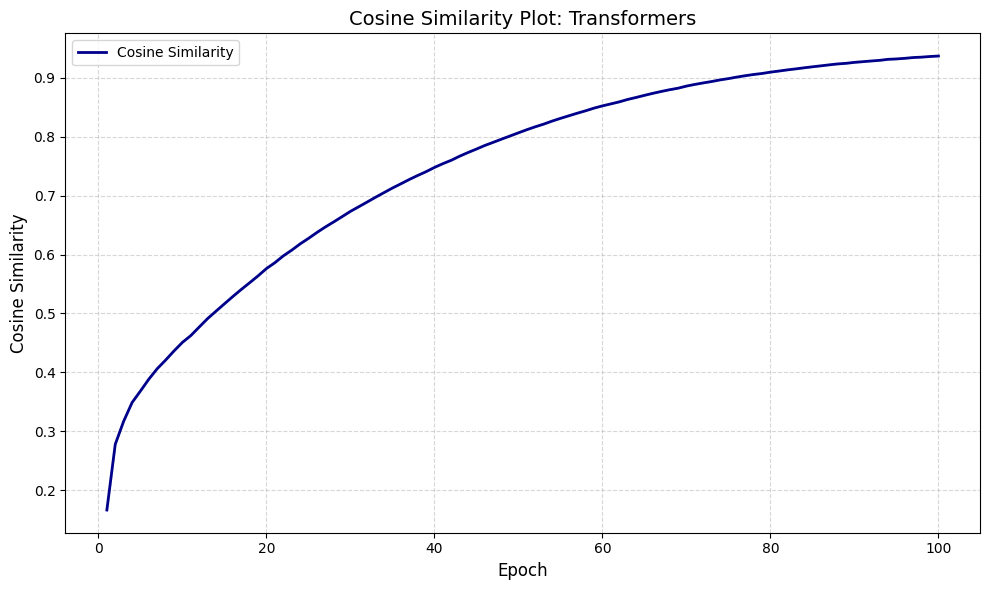

[PLOT] Similarity curve saved to /content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models/cosine_similarity_plot.png


In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────
# Device Configuration
# ───────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[DEVICE] Using device: {device}")

# ───────────────────────────────────────────────────────
# Data Info
# ───────────────────────────────────────────────────────
# Get brain activity input shape from a sample batch
sample_batch = next(iter(train_loader))
_, sample_brain = sample_batch
brain_input_dim = sample_brain.shape[1]  # Inferred automatically
latent_space_dim = 512  # Must match encoder output of autoencoder

print(f"[INFO] Brain activity input dimension: {brain_input_dim}")
print(f"[INFO] Latent space dimension expected: {latent_space_dim}")

# ───────────────────────────────────────────────────────
# Positional Encoding Module
# ───────────────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.transpose(0, 1))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# ───────────────────────────────────────────────────────
# Transformer Decoder Architecture
# ───────────────────────────────────────────────────────
class TransformerBrainDecoder(nn.Module):
    def __init__(self, input_dim, d_model=512, nhead=4, num_layers=6, dim_feedforward=2048, dropout=0.1, latent_dim=512):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, latent_dim)
        )

    def forward(self, x):
        x = self.input_projection(x).unsqueeze(1)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return self.output_projection(x.squeeze(1))

# ───────────────────────────────────────────────────────
# Loss Function (Cosine Similarity)
# ───────────────────────────────────────────────────────
class CosineSimilarityLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CosineEmbeddingLoss()

    def forward(self, input1, input2):
        target = torch.ones(input1.size(0)).to(input1.device)
        return self.loss(input1, input2, target)

# ───────────────────────────────────────────────────────
# Model Initialization
# ───────────────────────────────────────────────────────
transformer_brain_decoder = TransformerBrainDecoder(input_dim=brain_input_dim, latent_dim=latent_space_dim).to(device)
optimizer = torch.optim.Adam(transformer_brain_decoder.parameters(), lr=1e-4)
criterion_cosine = CosineSimilarityLoss()

# ───────────────────────────────────────────────────────
# Checkpoint and Log Paths
# ───────────────────────────────────────────────────────
base_dir = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models"
checkpoint_path = os.path.join(base_dir, "transformer_decoder_checkpoint.pth")
cosine_log_path = os.path.join(base_dir, "transformer_cosine_similarity.pt")
plot_path = os.path.join(base_dir, "cosine_similarity_plot.png")

## ───────────────────────────────────────────────────────
# Load Checkpoint if Exists
# ───────────────────────────────────────────────────────
start_epoch = 0
cosine_means = []
cosine_stds = []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)  # Fix 1
    transformer_brain_decoder.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    cosine_means = checkpoint.get("cosine_similarity_values", [])
    print(f"[CHECKPOINT] Loaded model from epoch {start_epoch}")


# ───────────────────────────────────────────────────────
# Training Loop
# ───────────────────────────────────────────────────────
epochs = 100
for epoch in range(start_epoch, epochs):
    transformer_brain_decoder.train()
    cosine_similarities = []

    for images, brain_activity in train_loader:
        images = images.to(device)
        brain_activity = brain_activity.to(device)

        with torch.no_grad():
            latent_code = autoencoder_model.encoder(images)

        z_brain = transformer_brain_decoder(brain_activity)
        loss = criterion_cosine(z_brain, latent_code)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cosine_similarities.append(1 - loss.item())

    # Epoch metrics
    mean_cosine = np.mean(cosine_similarities)
    std_cosine = np.std(cosine_similarities)
    cosine_means.append(mean_cosine)
    cosine_stds.append(std_cosine)

    print(f"📘 Epoch [{epoch+1}/{epochs}] | Cosine Similarity: {mean_cosine:.4f} ± {std_cosine:.4f}")

    # Save checkpoint
    torch.save({
        "epoch": epoch,
        "model_state_dict": transformer_brain_decoder.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "cosine_similarity_values": cosine_means,
    }, checkpoint_path)
    print(f"[SAVE] Model checkpoint saved at epoch {epoch+1}.")

# ───────────────────────────────────────────────────────
# Save Similarity Log
# ───────────────────────────────────────────────────────
torch.save(cosine_means, cosine_log_path)
print(f"[LOG] Cosine similarity values saved to {cosine_log_path}")

# ───────────────────────────────────────────────────────
# Plot Results
# ───────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(cosine_means) + 1)  # Adjust to actual length

# Ensuring cosine_stds matches cosine_means length
if len(cosine_stds) != len(cosine_means):
    cosine_stds = [0] * len(cosine_means)

plt.plot(epochs_range, cosine_means, label="Cosine Similarity", color="darkblue", linewidth=2)
plt.fill_between(
    epochs_range,
    np.array(cosine_means) - np.array(cosine_stds),
    np.array(cosine_means) + np.array(cosine_stds),
    color="lightblue", alpha=0.4
)

plt.grid(True, linestyle='--', alpha=0.5)
plt.title("Cosine Similarity Plot: Transformers", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cosine Similarity", fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

print(f"[PLOT] Similarity curve saved to {plot_path}")

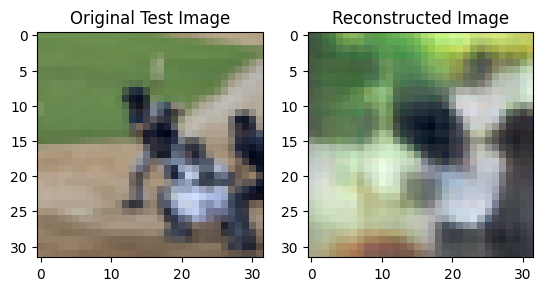

In [ ]:
# First you get the brain activity from train loader
image, brain_activity = next(iter(train_loader))

# Pasing it to the brain decoder.....
z_brain = transformer_brain_decoder(brain_activity.to(device))
# Third you pass z_brain (latent code) thorugh the decoder of the autoencoder
reconstructed_image = autoencoder_model.decoder(z_brain)
reconstructed_image = reconstructed_image.detach().to('cpu')
fig, ax = plt.subplots(1,2)
showImage(ax[0], image[0, :, :, :], title = 'Original Test Image')
showImage(ax[1], reconstructed_image[0, :, :, :], 'Reconstructed Image')


## Experiments: GAN

In [ ]:
import os

test_dir = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/algonauts_2023_tutorial_data/subj01/test_split/test_images"
train_dir = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/algonauts_2023_tutorial_data/subj01/training_split/training_images"

print("Test files:", len(os.listdir(test_dir)))
print("Train files:", len(os.listdir(train_dir)))


Test files: 159
Train files: 9841


### **Training GAN using FMRI**


Starting training...
[1/400] Loss_D: 1.0149 | Loss_G: 1.9496
[2/400] Loss_D: 0.7412 | Loss_G: 3.1118
[3/400] Loss_D: 0.8111 | Loss_G: 2.6652
[4/400] Loss_D: 0.6707 | Loss_G: 2.8055
[5/400] Loss_D: 0.8007 | Loss_G: 1.7044
[6/400] Loss_D: 0.7108 | Loss_G: 2.5509
[7/400] Loss_D: 0.8589 | Loss_G: 2.4992
[8/400] Loss_D: 0.6386 | Loss_G: 2.7628
[9/400] Loss_D: 0.6900 | Loss_G: 2.2233
[10/400] Loss_D: 0.8360 | Loss_G: 2.2146
[11/400] Loss_D: 0.4777 | Loss_G: 2.8383
[12/400] Loss_D: 0.4870 | Loss_G: 3.0637
[13/400] Loss_D: 0.5443 | Loss_G: 3.3772
[14/400] Loss_D: 0.6189 | Loss_G: 5.2252
[15/400] Loss_D: 0.8477 | Loss_G: 4.8577
[16/400] Loss_D: 0.4759 | Loss_G: 3.5660
[17/400] Loss_D: 0.4085 | Loss_G: 3.0469
[18/400] Loss_D: 0.5918 | Loss_G: 2.4801
[19/400] Loss_D: 1.0696 | Loss_G: 2.8159
[20/400] Loss_D: 0.2124 | Loss_G: 3.6917
[21/400] Loss_D: 0.3070 | Loss_G: 5.6799
[22/400] Loss_D: 0.4713 | Loss_G: 3.7983
[23/400] Loss_D: 0.1911 | Loss_G: 3.6926
[24/400] Loss_D: 0.2644 | Loss_G: 5.6465
[25/

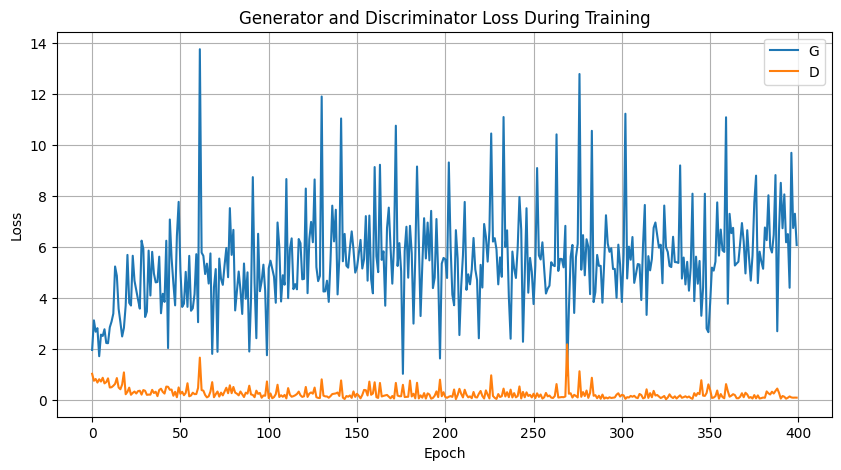

Loss graph saved to: /content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models/loss_plot.png


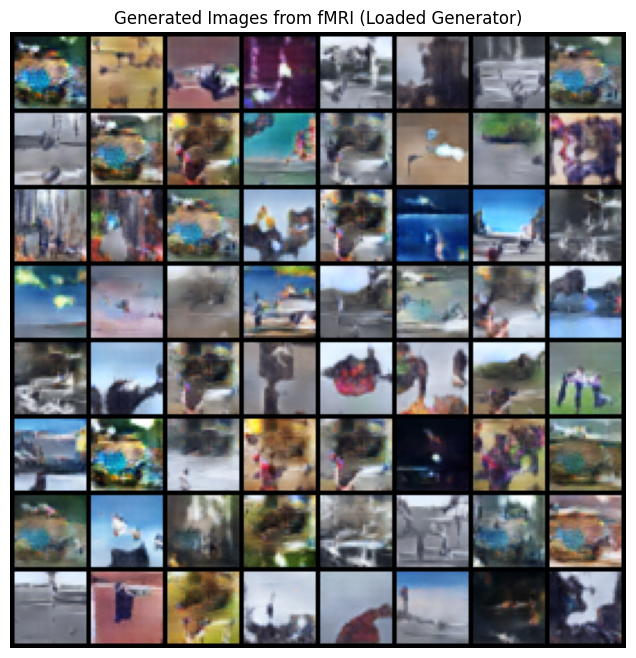

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

# --- Config ---
batch_size = 64
lr = 0.0002
num_epochs = 400
input_dim = 20544
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Output directory for saving model and plots
output_dir = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models"
os.makedirs(output_dir, exist_ok=True)

# --- Models ---
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256 * 4 * 4),
            nn.ReLU(True)
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x).view(-1, 256, 4, 4)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize models
netG = Generator(input_dim=input_dim).to(device)
netD = Discriminator().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# DataLoader (ensure `myDataset` is defined)
train_loader = DataLoader(dataset=myDataset, batch_size=batch_size, shuffle=True)

# --- Track losses ---
G_losses, D_losses = [], []

# --- Training ---
print("Starting training...")
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        real_images = data[0].to(device)
        fmri_input = data[1].to(device).float()
        b_size = real_images.size(0)

        # Train Discriminator
        netD.zero_grad()
        label = torch.full((b_size,), 1.0, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()

        fake_images = netG(fmri_input)
        label.fill_(0.0)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(1.0)
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    # Save losses
    G_losses.append(errG.item())
    D_losses.append((errD_real + errD_fake).item())

    print(f"[{epoch+1}/{num_epochs}] Loss_D: {(errD_real + errD_fake):.4f} | Loss_G: {errG:.4f}")

# --- Save the Generator ---
torch.save(netG.state_dict(), os.path.join(output_dir, "netG.pth"))
print(f"Trained Generator saved to: {output_dir}/netG.pth")

# --- Plot & Save Loss Graph ---
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "loss_plot.png"))
plt.show()
print(f"Loss graph saved to: {output_dir}/loss_plot.png")

# --- Inference using saved model ---
# Load saved Generator
netG = Generator(input_dim=input_dim).to(device)
netG.load_state_dict(torch.load(os.path.join(output_dir, "netG.pth"), map_location=device))
netG.eval()

# Run inference on sample fMRI input
with torch.no_grad():
    sample_data = next(iter(train_loader))
    fmri_sample = sample_data[1][:64].to(device).float()
    fake_images = netG(fmri_sample).cpu()

# Visualize generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images from fMRI (Loaded Generator)")
plt.imshow(vutils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
plt.show()



### GAN INFERENCE

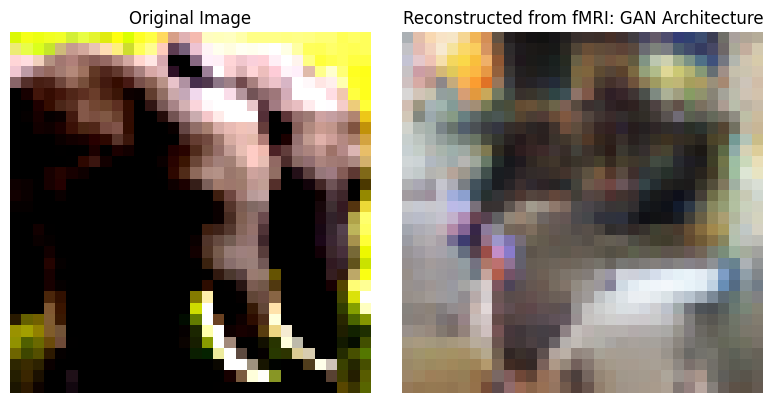

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generator definition
class Generator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 256 * 4 * 4),
            torch.nn.ReLU(True)
        )
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x).view(-1, 256, 4, 4)
        return self.main(x)

# Initialize and load the pretrained generator
input_dim = 20544
netG = Generator(input_dim=input_dim).to(device)

model_path = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models/netG.pth"
netG.load_state_dict(torch.load(model_path, map_location=device))
netG.eval()

# Get a batch from your dataset (use test_loader if available)
img_batch, fmri_batch = next(iter(train_loader))  # You can replace this with test_loader

# Pick one test sample
real_img = img_batch[0]
fmri_vector = fmri_batch[0].unsqueeze(0).to(device).float()  # Shape: [1, 20544]

# Generate image from fMRI vector
with torch.no_grad():
    generated_img = netG(fmri_vector).cpu()  # Output shape: [1, 3, 32, 32]

# Plot real vs generated
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(real_img.permute(1, 2, 0))
ax[0].set_title("Original Image")
ax[0].axis("off")

# Normalize generated image to [0,1]
gen_img_display = (generated_img[0] + 1) / 2
ax[1].imshow(gen_img_display.permute(1, 2, 0))
ax[1].set_title("Reconstructed from fMRI: GAN Architecture")
ax[1].axis("off")

plt.tight_layout()
plt.show()

# Optionally save the comparison figure
save_path = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models/inference_comparison.png"
fig.savefig(save_path)


<!-- ## LLM (trail) -->

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[0/150][0/154] Loss_D: 1.4553 Loss_G: 2.4977
[0/150][100/154] Loss_D: 1.0950 Loss_G: 3.0537
[1/150][0/154] Loss_D: 1.2503 Loss_G: 2.5406
[1/150][100/154] Loss_D: 0.5472 Loss_G: 2.9999
[2/150][0/154] Loss_D: 0.4852 Loss_G: 2.9676
[2/150][100/154] Loss_D: 0.8027 Loss_G: 3.8182
[3/150][0/154] Loss_D: 0.6795 Loss_G: 3.8367
[3/150][100/154] Loss_D: 0.3751 Loss_G: 3.9010
[4/150][0/154] Loss_D: 0.4221 Loss_G: 3.3691
[4/150][100/154] Loss_D: 0.5659 Loss_G: 7.1328
[5/150][0/154] Loss_D: 0.1813 Loss_G: 3.7743
[5/150][100/154] Loss_D: 0.1693 Loss_G: 3.9713
[6/150][0/154] Loss_D: 0.1394 Loss_G: 4.9169
[6/150][100/154] Loss_D: 0.1382 Loss_G: 4.3343
[7/150][0/154] Loss_D: 0.0510 Loss_G: 4.3842
[7/150][100/154] Loss_D: 0.1275 Loss_G: 3.8049
[8/150][0/154] Loss_D: 0.1443 Loss_G: 5.1293
[8/150][100/154] Loss_D: 0.0687 Loss_G: 4.3777
[9/150][0/154] Loss_D: 0.0788 Loss_G: 4.2435
[9/150][100/154] Loss_D: 0.0162 Loss_G: 5.8263
[10/150][0/154] Loss_D: 0.0846 Loss_G: 4.5185
[10/150][100/154] Loss_D: 0.0609 L

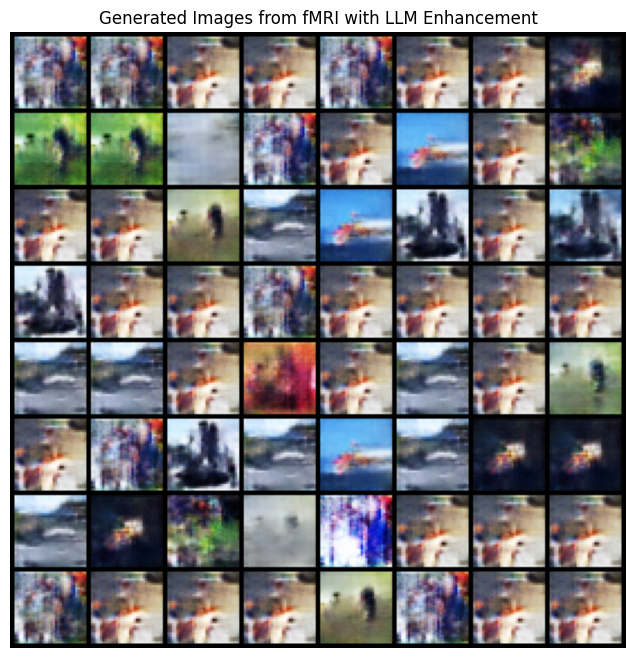

In [ ]:
# Enhanced GAN with LLM module for fMRI-to-Image Reconstruction

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
lr = 0.0002
num_epochs = 150
input_dim = 20544  # fMRI input size
compressed_dim = 512  # Intermediate compression size
latent_dim = 256 * 4 * 4  # Output size before Generator conv
num_transformer_layers = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === fMRI Encoder (MLP) ===
class fMRIEncoder(nn.Module):
    def __init__(self, input_dim, compressed_dim):
        super(fMRIEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(True),
            nn.Linear(4096, compressed_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.fc(x)

# === Lightweight Transformer (LLM block) ===
class SmallTransformer(nn.Module):
    def __init__(self, dim, num_layers=3, num_heads=8):
        super(SmallTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # x: [batch_size, feature_dim] -> add seq_len=1 for Transformer
        x = x.unsqueeze(1)  # (batch, seq_len=1, feature_dim)
        x = self.transformer(x)
        return x.squeeze(1)  # back to (batch, feature_dim)

# === Generator ===
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(True)
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),    # 32x32
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x).view(-1, 256, 4, 4)
        return self.main(x)

# === Discriminator ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# === Initialize models ===
fmri_encoder = fMRIEncoder(input_dim=input_dim, compressed_dim=compressed_dim).to(device)
llm_block = SmallTransformer(dim=compressed_dim, num_layers=num_transformer_layers).to(device)
netG = Generator(latent_dim=compressed_dim).to(device)
netD = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(list(fmri_encoder.parameters()) + list(llm_block.parameters()) + list(netG.parameters()), lr=lr, betas=(0.5, 0.999))

# Dataloader (your dataset should return (image, fmri_vector))
train_loader = DataLoader(dataset=myDataset, batch_size=batch_size, shuffle=True)

# === Training Loop ===
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        real_images = data[0].to(device)
        fmri_input = data[1].to(device).float()
        b_size = real_images.size(0)

        ## --- Train Discriminator ---
        netD.zero_grad()
        label = torch.full((b_size,), 1.0, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Generate fake images
        compressed_fmri = fmri_encoder(fmri_input)
        transformed_fmri = llm_block(compressed_fmri)
        fake_images = netG(transformed_fmri)

        label.fill_(0.0)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        ## --- Train Generator + fMRI Encoder + LLM ---
        netG.zero_grad()
        fmri_encoder.zero_grad()
        llm_block.zero_grad()
        label.fill_(1.0)
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(train_loader)}] Loss_D: {(errD_real + errD_fake):.4f} Loss_G: {errG:.4f}")

# === Visualization ===
with torch.no_grad():
    sample_data = next(iter(train_loader))
    fmri_batch = sample_data[1][:64].to(device).float()
    compressed_fmri = fmri_encoder(fmri_batch)
    transformed_fmri = llm_block(compressed_fmri)
    fake = netG(transformed_fmri).cpu()

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images from fMRI with LLM Enhancement")
plt.imshow(vutils.make_grid(fake, padding=2, normalize=True).permute(1,2,0))
plt.show()



## LLM-BASED APPROACH: MAIN RESULTS

In [ ]:
#SETTING UP LLMS ENVIROMENT !

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-a2xr6a5_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-a2xr6a5_
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=33cf80cad80ee7823007eaab1a5fc0f745cb86511470030c174d8a0bca12b0a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-upvx4tpf/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip
  Attempting uninstall: clip
    Found existing installation: clip 0.2.0
    Uninstalling clip-0.2.0:
      Successfully uninstalled clip-0.2.0


In [ ]:
# # First uninstall any existing versions to avoid conflicts
# !pip uninstall open-clip-torch clip -y

# # Then install the correct package
# !pip install open-clip-torch

# # Additional dependencies you might need
# !pip install torch torchvision transformers diffusers

Found existing installation: open_clip_torch 2.32.0
Uninstalling open_clip_torch-2.32.0:
  Successfully uninstalled open_clip_torch-2.32.0
Found existing installation: clip 0.2.0
Uninstalling clip-0.2.0:
  Successfully uninstalled clip-0.2.0
  Using cached open_clip_torch-2.32.0-py3-none-any.whl.metadata (31 kB)
Using cached open_clip_torch-2.32.0-py3-none-any.whl (1.5 MB)


In [ ]:
# !pip install torch transformers diffusers clip matplotlib
!pip install torch transformers diffusers matplotlib

  Using cached clip-0.2.0-py3-none-any.whl


In [ ]:
import clip  # This is the official OpenAI CLIP

# Load CLIP model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

# For text tokenization with official CLIP:
def clip_tokenize(texts):
    return clip.tokenize(texts, truncate=True).to(device)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 45.6MiB/s]


### LLM Inference

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zzdqme88
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zzdqme88
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
# # First uninstall any existing versions to avoid conflicts
# !pip uninstall open-clip-torch clip -y

# # Then install the correct package
!pip install open-clip-torch
# # !pip install clip
# # # Additional dependencies you might need
# !pip install torch torchvision transformers diffusers

In [ ]:
import clip  # This is the official OpenAI CLIP

# Load CLIP model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

# For text tokenization with official CLIP:
def clip_tokenize(texts):
    return clip.tokenize(texts, truncate=True).to(device)

### Training + Inference

Epoch [1/50] Step [0] Loss: 0.9764
Epoch [1/50] - Avg Loss: 0.9806, Avg Cosine Similarity: 0.0194
Epoch [2/50] Step [0] Loss: 0.4697
Epoch [2/50] - Avg Loss: 0.2954, Avg Cosine Similarity: 0.7046
Epoch [3/50] Step [0] Loss: 0.1442
Epoch [3/50] - Avg Loss: 0.1112, Avg Cosine Similarity: 0.8888
Epoch [4/50] Step [0] Loss: 0.0792
Epoch [4/50] - Avg Loss: 0.0675, Avg Cosine Similarity: 0.9325
Epoch [5/50] Step [0] Loss: 0.0540
Epoch [5/50] - Avg Loss: 0.0477, Avg Cosine Similarity: 0.9523
Epoch [6/50] Step [0] Loss: 0.0408
Epoch [6/50] - Avg Loss: 0.0366, Avg Cosine Similarity: 0.9634
Epoch [7/50] Step [0] Loss: 0.0313
Epoch [7/50] - Avg Loss: 0.0292, Avg Cosine Similarity: 0.9708
Epoch [8/50] Step [0] Loss: 0.0255
Epoch [8/50] - Avg Loss: 0.0241, Avg Cosine Similarity: 0.9759
Epoch [9/50] Step [0] Loss: 0.0200
Epoch [9/50] - Avg Loss: 0.0204, Avg Cosine Similarity: 0.9796
Epoch [10/50] Step [0] Loss: 0.0182
Epoch [10/50] - Avg Loss: 0.0174, Avg Cosine Similarity: 0.9826
Epoch [11/50] Step

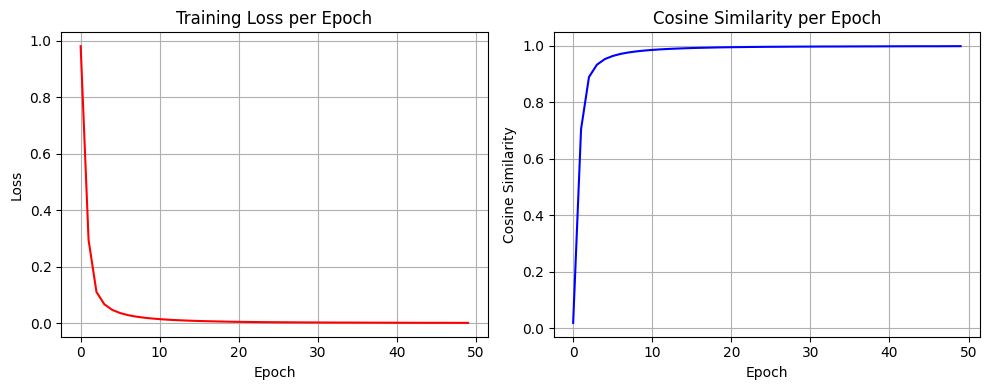

Cosine similarity between predicted and true embedding: -0.1184

BLIP-generated captions for the image:
- a person on a dirt bike in the air
- a man on a dirt bike in the air
- a man riding a dirt bike in the air

Generating image from best caption via Stable Diffusion...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

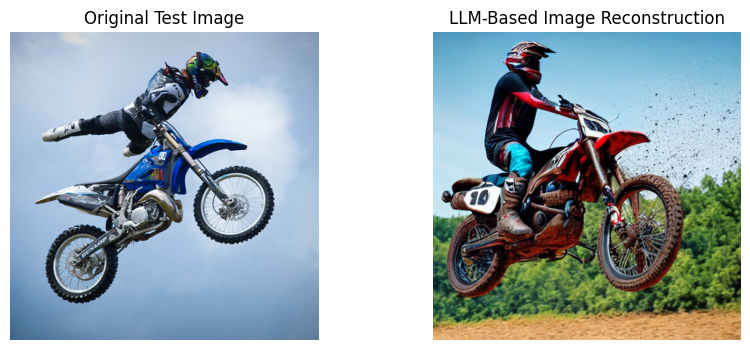

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BlipProcessor, BlipForConditionalGeneration
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import open_clip
import os
import numpy as np

# Paths and constants
save_dir = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/models"
os.makedirs(save_dir, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 20544  # fMRI vector size
latent_dim = 512
lr = 1e-4
batch_size = 32
num_epochs = 50

# Load CLIP model
clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="laion2b_s34b_b79k", device=device
)
clip_tokenizer = open_clip.get_tokenizer("ViT-B-32")
for p in clip_model.parameters():
    p.requires_grad = False

# FMRI Adapter model
class FMRIAdapter(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, output_dim)
        )

    def forward(self, x):
        return self.model(x)

adapter = FMRIAdapter(input_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(adapter.parameters(), lr=lr)

class BrainDataset(Dataset):
    def __init__(self, fmri_dir, image_dir, image_filenames, transform=None):
        self.fmri_dir = fmri_dir
        self.image_dir = image_dir
        self.image_filenames = image_filenames  # list of filenames without extensions if needed
        self.transform = transform if transform else T.Compose([
            T.Resize((224, 224)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]

        # Load image
        img_path = os.path.join(self.image_dir, img_name + ".png")
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # Load fMRI
        fmri_path = os.path.join(self.fmri_dir, img_name + ".npy")
        fmri = torch.from_numpy(np.load(fmri_path)).float()

        return image, fmri


train_loader = DataLoader(BrainDataset(), batch_size=batch_size, shuffle=True)

# Transform single image
def clip_transform(image):
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)
    return preprocess(image).unsqueeze(0).to(device)

# Training loop
def train():
    adapter.train()
    epoch_losses = []
    epoch_similarities = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_sim = 0.0
        count = 0

        for i, (images, fmri) in enumerate(train_loader):
            fmri = fmri.to(device).float()
            images = torch.stack([clip_transform(img) for img in images]).squeeze(1)

            with torch.no_grad():
                target_embeddings = clip_model.encode_image(images.to(device))

            predicted_embeddings = adapter(fmri)
            cosine_sim = torch.cosine_similarity(predicted_embeddings, target_embeddings)
            loss = 1 - cosine_sim.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_sim += cosine_sim.mean().item()
            count += 1

            if i % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}] Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / count
        avg_sim = epoch_sim / count
        epoch_losses.append(avg_loss)
        epoch_similarities.append(avg_sim)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}, Avg Cosine Similarity: {avg_sim:.4f}")
        torch.save(adapter.state_dict(), f"{save_dir}/adapter_epoch_{epoch+1}.pth")

    print("Training complete.")
    torch.save(adapter.state_dict(), f"{save_dir}/final_adapter.pth")

    # Plot Loss and Similarity
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Loss', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_similarities, label='Cosine Similarity', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Cosine Similarity")
    plt.title("Cosine Similarity per Epoch")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Inference: Use image to simulate embedding, compare with adapter
def infer_from_image(image_path):
    adapter.eval()

    # Load and preprocess test image
    raw_image = Image.open(image_path).convert('RGB')
    clip_image = clip_transform(raw_image)

    # Get actual image embedding
    with torch.no_grad():
        actual_embedding = clip_model.encode_image(clip_image)

    # (Simulated) fMRI → predicted embedding
    dummy_fmri = torch.randn(1, input_dim).to(device)
    predicted_embedding = adapter(dummy_fmri)

    # Compare similarity
    similarity = torch.cosine_similarity(predicted_embedding, actual_embedding).item()
    print(f"Cosine similarity between predicted and true embedding: {similarity:.4f}")

    # Use BLIP to caption the image
    print("\nBLIP-generated captions for the image:")
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

    inputs = blip_processor(raw_image, return_tensors="pt").to(device)
    for _ in range(3):
        out = blip_model.generate(**inputs, max_length=30, num_beams=5, do_sample=True, temperature=1.0)
        caption = blip_processor.decode(out[0], skip_special_tokens=True)
        print(f"- {caption}")

    # Use Stable Diffusion on top caption
    print("\nGenerating image from best caption via Stable Diffusion...")
    sd_pipeline = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    ).to(device)

    generated_image = sd_pipeline(caption, num_inference_steps=30).images[0]

    # Display both
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image)
    plt.axis('off')
    plt.title("Original Test Image")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_image)
    plt.axis('off')
    plt.title("LLM-Based Image Reconstruction")
    plt.show()

# Run the training and inference
if __name__ == "__main__":
    train()

    test_image_path = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/algonauts_2023_tutorial_data/subj01/test_split/test_images/test-0001_nsd-00845.png"
    infer_from_image(test_image_path)


Cosine similarity between predicted and true embedding: 0.3887

BLIP-generated captions for the image:
- an old oven sitting on the side of a road
- an old oven is sitting in the middle of a parking lot
- an old oven sitting on the side of a road

Generating image from best caption via Stable Diffusion...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

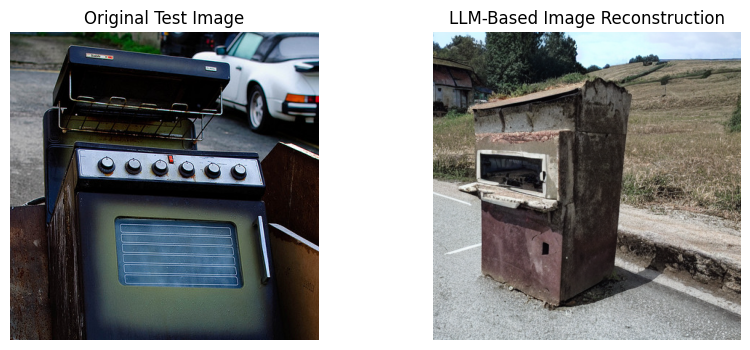

In [ ]:
test_image_path = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/algonauts_2023_tutorial_data/subj01/test_split/test_images/test-0002_nsd-00946.png"
infer_from_image(test_image_path)


Cosine similarity between predicted and true embedding: 0.1672

BLIP-generated captions for the image:
- a vase of flowers sitting on a window sie
- a vase of flowers sitting on a window sie
- a vase of flowers sitting on a window sie

Generating image from best caption via Stable Diffusion...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

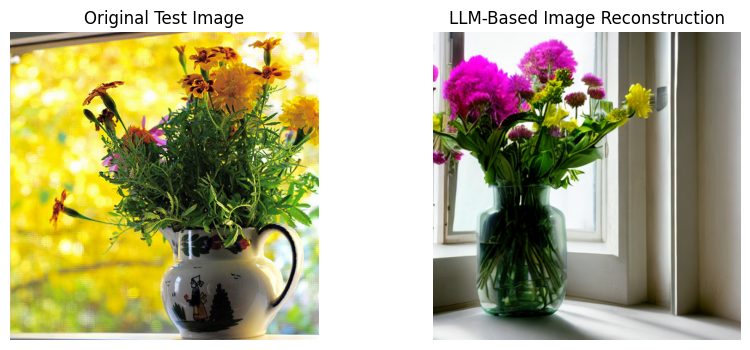

In [ ]:
test_image_path = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/algonauts_2023_tutorial_data/subj01/test_split/test_images/test-0003_nsd-01517.png"
infer_from_image(test_image_path)


Cosine similarity between predicted and true embedding: -0.1114

BLIP-generated captions for the image:
- a pizza sitting on a white plate on a table
- a pizza sitting on a plate on a table
- a pizza on a white plate

Generating image from best caption via Stable Diffusion...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

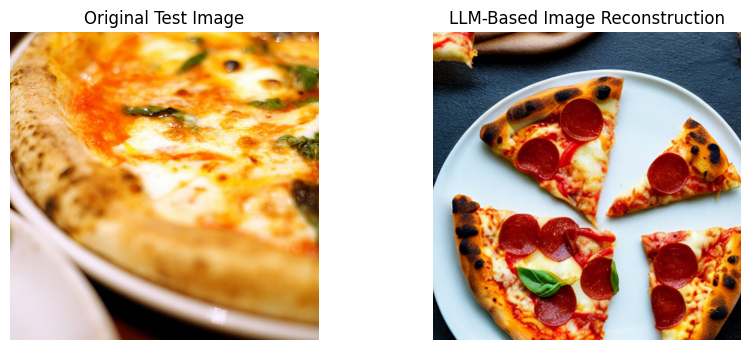

In [ ]:
test_image_path = "/content/drive/MyDrive/SHU/Neural Networks and Learning Systems/algonauts_2023_tutorial_data/subj01/test_split/test_images/test-0009_nsd-04067.png"
infer_from_image(test_image_path)
